In [1]:
#Import Beautiful Soup, lxml, requests to scrap data from Toronto Neighborhood in Wikipedia
!pip install wikipedia
from bs4 import BeautifulSoup
import wikipedia as wp
import numpy as np 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries Imported!")

Libraries Imported!


# Get Table from Wikipedia 

In [2]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
#delete Borough which is not assigned
df = df[df['Borough']!= 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [5]:
df['Neighborhood'].unique()

array(['Parkwoods', 'Victoria Village', 'Regent Park, Harbourfront',
       'Lawrence Manor, Lawrence Heights',
       "Queen's Park, Ontario Provincial Government",
       'Islington Avenue, Humber Valley Village', 'Malvern, Rouge',
       'Don Mills', 'Parkview Hill, Woodbine Gardens',
       'Garden District, Ryerson', 'Glencairn',
       'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale',
       'Rouge Hill, Port Union, Highland Creek', 'Woodbine Heights',
       'St. James Town', 'Humewood-Cedarvale',
       'Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood',
       'Guildwood, Morningside, West Hill', 'The Beaches', 'Berczy Park',
       'Caledonia-Fairbanks', 'Woburn', 'Leaside', 'Central Bay Street',
       'Christie', 'Cedarbrae', 'Hillcrest Village',
       'Bathurst Manor, Wilson Heights, Downsview North',
       'Thorncliffe Park', 'Richmond, Adelaide, King',
       'Dufferin, Dovercourt Village', 'Scarborough Village',
       'Fairview, H

In [6]:
#combine neighbourhoods where postcode & Borough are the same
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(lambda x:', '.join(x)).to_frame().reset_index()

In [7]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] == df['Borough']
    

In [9]:
colnames = ['Postcode','Borough','Neighborhood']
df.columns = colnames

In [10]:
df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


# Add geographical coordinates to the neighborhoods

In [11]:
import pandas as pd
import io
import requests

url="https://cocl.us/Geospatial_data"
s=requests.get(url).content #bytes
lat_lng=pd.read_csv(io.StringIO(s.decode('utf-8'))) #s.decode: change bytes to string to _io.StringIO
lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
#merge lat_lng to df
lat_lng = lat_lng.rename(columns={'Postal Code':'Postcode'})
toronto_df = pd.merge(df, lat_lng, on='Postcode')
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
       len(toronto_df['Borough'].unique()),
       toronto_df.shape[0]))  # shape check the dimension of df(n,m)

The dataframe has 10 boroughs and 103 neighborhoods.


# Scrap the distribution of population from wilipedia

In [14]:
html = wp.page('Demographics of Toronto').html().encode('UTF-8')

In [15]:
demo_df = pd.read_html(html)
demo_df = pd.DataFrame(demo_df)[0]

In [16]:
#TORONTO & EAST YORK
demo_df[12]

,Riding,Population,Ethnic Origin #1,%,Ethnic Origin #2,%.1,Ethnic Origin #3,%.2,Ethnic Origin #4,%.3,Ethnic Origin #5,%.4,Ethnic Origin #6,%.5,Ethnic Origin #7,%.6,Ethnic Origin #8,%.7,Ethnic Origin #9,%.8
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#NORTH YORK
demo_df[13]

,Riding,Population,Ethnic Origin #1,%,Ethnic Origin #2,%.1,Ethnic Origin #3,%.2,Ethnic Origin #4,%.3,Ethnic Origin #5,%.4,Ethnic Origin #6,%.5,Ethnic Origin #7,%.6,Ethnic Origin #8,%.7
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [18]:
#SCARBOROUGH
demo_df[14]

,Riding,Population,Ethnic Origin #1,%,Ethnic Origin #2,%.1,Ethnic Origin #3,%.2,Ethnic Origin #4,%.3,Ethnic Origin #5,%.4,Ethnic Origin #6,%.5,Ethnic Origin #7,%.6,Ethnic Origin #8,%.7
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#ETOBICOKE & YORK
demo_df[15]

,Riding,Population,Ethnic Origin #1,%,Ethnic Origin #2,%.1,Ethnic Origin #3,%.2,Ethnic Origin #4,%.3,Ethnic Origin #5,%.4,Ethnic Origin #6,%.5,Ethnic Origin #7,%.6,Ethnic Origin #8,%.7
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
toronto_df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke'], dtype=object)

# Get location data using Foursquare

In [21]:
#Get geographical coordinate of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [22]:
#Connect Foursquare
CLIENT_ID = 'JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE' # your Foursquare ID
CLIENT_SECRET = 'F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
#print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE
CLIENT_SECRET:F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ


'https://api.foursquare.com/v2/venues/search?client_id=JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE&client_secret=F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ&ll=43.6534817,-79.3839347&v=20180604&radius=500&limit=100'

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
#Send the GET request and examine the results
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,4c093ee0340720a153728493,NaN,CA,NaN,Canada,NaN,184,[Canada],"[{'label': 'display', 'lat': 43.65182710471462...",43.651827,-79.383949,NaN,NaN,City Hall Council Chambers,v-1591113468
1,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,4ad4c05ef964a5208ff620e3,100 Queen St. W.,CA,Toronto,Canada,at Bay St.,38,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...","[{'label': 'display', 'lat': 43.65313989695342...",43.653140,-79.383967,M5H 2N2,ON,Toronto City Hall,v-1591113468
2,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,5b193c42598e64002ca79b96,100 Queen St W,CA,Toronto,Canada,NaN,3,"[100 Queen St W, Toronto ON M5H 2N2, Canada]","[{'label': 'display', 'lat': 43.653454, 'lng':...",43.653454,-79.383952,M5H 2N2,ON,City of Toronto Civic Innovation Office,v-1591113468
3,"[{'id': '4bf58dd8d48988d126941735', 'name': 'G...",False,5a81bb73e7a2370cf92452dc,NaN,CA,Toronto,Canada,NaN,47,"[Toronto ON M5G, Canada]","[{'label': 'display', 'lat': 43.653119, 'lng':...",43.653119,-79.384252,M5G,ON,Service Canada,v-1591113468
4,"[{'id': '4bf58dd8d48988d12f941735', 'name': 'L...",False,4c8938c8944e224b52e72285,100 Queen St W,CA,Toronto,Canada,City Hall,107,"[100 Queen St W (City Hall), Toronto ON M5H 2N...","[{'label': 'display', 'lat': 43.65263139770985...",43.652631,-79.383295,M5H 2N3,ON,Toronto Public Library,v-1591113468


In [25]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,City Hall Council Chambers,City Hall,NaN,CA,NaN,Canada,NaN,184,[Canada],"[{'label': 'display', 'lat': 43.65182710471462...",43.651827,-79.383949,NaN,NaN,4c093ee0340720a153728493
1,Toronto City Hall,City Hall,100 Queen St. W.,CA,Toronto,Canada,at Bay St.,38,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...","[{'label': 'display', 'lat': 43.65313989695342...",43.653140,-79.383967,M5H 2N2,ON,4ad4c05ef964a5208ff620e3
2,City of Toronto Civic Innovation Office,City Hall,100 Queen St W,CA,Toronto,Canada,NaN,3,"[100 Queen St W, Toronto ON M5H 2N2, Canada]","[{'label': 'display', 'lat': 43.653454, 'lng':...",43.653454,-79.383952,M5H 2N2,ON,5b193c42598e64002ca79b96
3,Service Canada,Government Building,NaN,CA,Toronto,Canada,NaN,47,"[Toronto ON M5G, Canada]","[{'label': 'display', 'lat': 43.653119, 'lng':...",43.653119,-79.384252,M5G,ON,5a81bb73e7a2370cf92452dc
4,Toronto Public Library,Library,100 Queen St W,CA,Toronto,Canada,City Hall,107,"[100 Queen St W (City Hall), Toronto ON M5H 2N...","[{'label': 'display', 'lat': 43.65263139770985...",43.652631,-79.383295,M5H 2N3,ON,4c8938c8944e224b52e72285


In [26]:
#Create function to know how many venues there are in Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#List of Neighborhood that have venues in Toronto
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [28]:
print('{} venues were returned by Foursquare.'.format(toronto_venues.shape[0]))
toronto_venues.head()

2133 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


# Folium Library and Leaflet Map

In [29]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], 
                                           toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Relationship between neighborhood and Chinese Restaurant

In [30]:
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [31]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [32]:
#Number of venues per neighborhood
toronto_venues.groupby('Neighborhood').count()
x = toronto_venues.groupby('Neighborhood').count()
x.index.name = 'Neighborhood'
x.reset_index(inplace = True)
x.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,5,5,5,5,5,5
1,"Alderwood, Long Branch",8,8,8,8,8,8
2,"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
3,Bayview Village,4,4,4,4,4,4
4,"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
manhattan_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
# add neighborhood column back to dataframe
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.

In [35]:
toronto_chinese = toronto_grouped[['Neighborhood','Chinese Restaurant']]
toronto_chinese.head()

,Neighborhood,Chinese Restaurant
0,Agincourt,0.00
1,"Alderwood, Long Branch",0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00
3,Bayview Village,0.25
4,"Bedford Park, Lawrence Manor East",0.00


In [36]:
toronto_merged = pd.merge(toronto_df, toronto_chinese, on='Neighborhood')

In [37]:
toronto_merged

,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.000000
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.000000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.000000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.000000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000000
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.000000
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.000000
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.000000
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0.000000
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.000000


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
ax = sns.violinplot(x="Borough", y="Chinese Restaurant", data=toronto_merged)
plt.show()

<Figure size 1800x600 with 1 Axes>

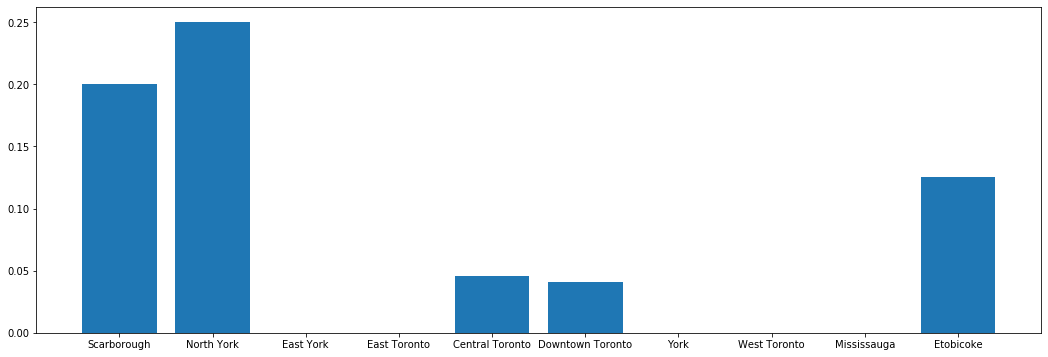

In [39]:
plt.figure(figsize = (18,6))
ax2 = plt.bar(x = 'Borough', height = 'Chinese Restaurant', data = toronto_merged)
plt.show()

In [40]:
#With the help of this violin plots we can identify the boroughs with densely populated Chinese restaurants. 
#It is drawn using seaborn library to show the distribution of Chinese restaurants in different boroughs.
##Let’s also visualize the neighborhood with Chinese Restaurants:

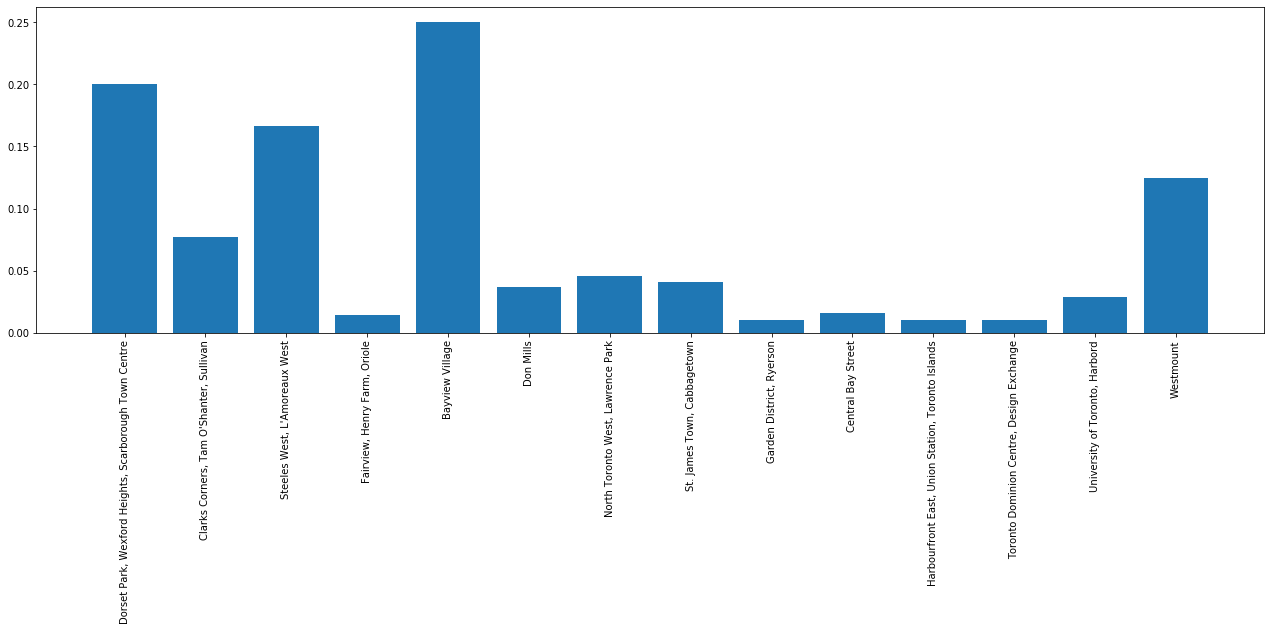

In [41]:
neighbor_form = toronto_merged[toronto_merged['Chinese Restaurant']>0]
plt.figure(figsize = (22,6))
ax2 = plt.bar(x = 'Neighborhood', height = 'Chinese Restaurant', data = neighbor_form)
plt.xticks(rotation=90)
plt.show()